<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand-vertical.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">2023-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'informàtica, multimèdia i telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 3: Control de temperatura

En les altres pràctiques haureu vist que la vostra tasca principal consistia en implementar algoritmes per solucionar entorns de gymnasium. En molts casos (especialment en el context de l'empresa) un no té els recursos ni el temps per poder implementar per si mateix algoritmes d'aprenentatge per reforç (reinforcement learning), i s'opta per utilitzar llibreries.

A l'igual que gymnasium (vist en les altres dues pràctiques) és utilitzat per definir i executar un entorn, existeix una llibreria anomenada [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/index.html) que implementa algoritmes de reinforcement learning. Aquesta llibreria és compatible amb gymnasium.

Què farem en aquesta pràctica? L'objectiu d'aquesta pràctica serà implementar un control de temperatures utilitzant stable-baselines3 i focalitzant-nos en alguns dels problemes que hem tractat superficialment en les altres PECS, com ara:

* Definir la millor representació del nostre espai d'observacions
* Definir la millor representació del nostre espai d'accions
* Selecció d'hiperparàmetres
* Modelització de la funció de recompensa


Algunes consideracions abans de començar la pràctica:

* És normal que en aquesta pràctica acabeu escrivint molt menys codi. Gran part del vostre temps durant la pràctica passarà per executar els algoritmes, així com llegir la documentació de stable-baselines3.

* Aquesta pràctica, **malgrat tractar-se de control de temperatura, NO REQUEREIX CONEIXEMENTS RELACIONATS AMB EL TEMA**. Totes les simulacions físiques necessàries per solucionar el problema estan implementades i testades i NO us heu de fixar en aquestes funcions


## 1. Introducció: Problema de control de temperatures


Per començar, instal·larem gymnasium i stable_baselines3. És recomanable fer servir Google Colab per evitar problemes de versions.

In [26]:
!pip install gymnasium==0.29.1
!pip install stable_baselines3==2.2.1


Anem a posar-nos en context. Imagineu que treballeu en una empresa dedicada al control de temperatures per a diverses aplicacions. S'està dissenyant un nou producte que ha de controlar la temperatura d'una àrea de 200x200 m2, que representarem utilitzant una matriu de 200x200 valors que indiquen la temperatura en cada punt. Per controlar la temperatura d'aquesta àrea, disposem d'una matriu de làmpades de 3x3 situades just sobre aquesta àrea. Aquestes làmpades són fonts de llum que irradieixen des de dalt la superfície a escalfar, com es mostra en l'esquema següent:


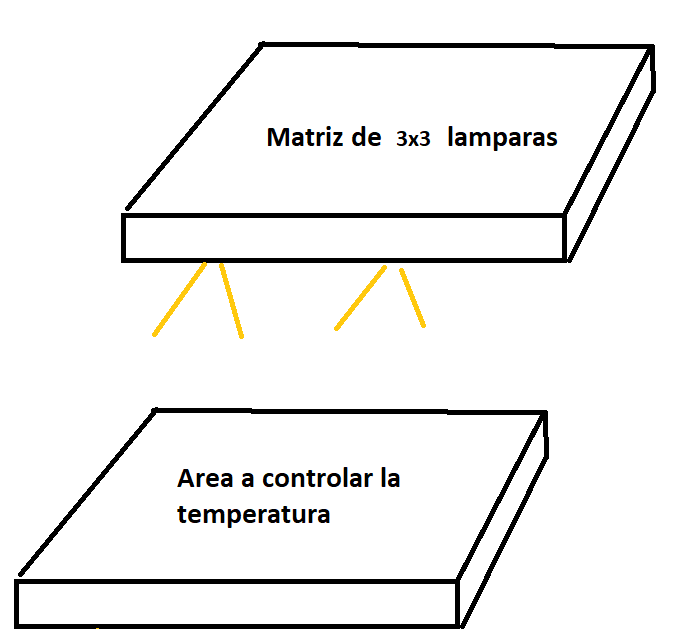

A la següent imatge es mostren amb una 'X' la posició de cadascuna de les làmpades respecte a la superfície de 200m2. També es mostra la 'empremta de calor' que deixa una làmpada sobre la superfície. Aquesta 'empremta de calor' no és res més que l'increment en temperatura que genera la làmpada quan s'encén. Fixeu-vos que la làmpada té un perfil difús i abasta una àrea bastant àmplia sota seu.

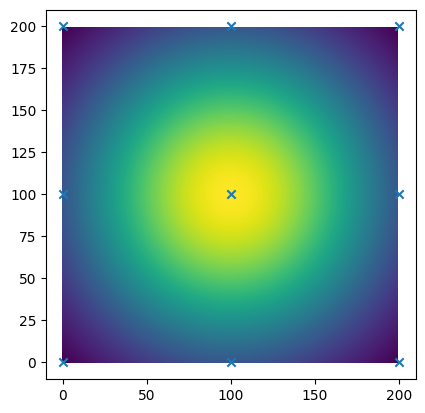

A més d'escalfar la superfície amb les làmpades, tenim, com en qualsevol superfície calenta, refredament degut a que la superfície està en contacte amb l'aire. Això fa que per mantenir la temperatura de la superfície en un cert valor, calgui que alguna de les làmpades (o totes) estiguin mínimament enceses per compensar aquestes pèrdues.

Què significa que volem 'controlar la temperatura'? El nostre producte ha de rebre com a entrada una temperatura objectiu i nosaltres hem d'anar modificant la potència de les làmpades perquè TOTS ELS PUNTS DE LA SUPERFÍCIE arribin, el més aviat possible, a una temperatura el més propera possible a la temperatura objectiu.

La potència de les làmpades s'ha normalitzat entre 0 i 1 de manera que una làmpada que estigui posada a una potència 0 estigui apagada i una làmpada posada a potència 1 estigui al seu màxim.

Per resumir:

* Tenim una matriu de 200x200 temperatures que volem que siguin el més semblants a una temperatura objectiu donada (target).

* Disposem d'una matriu de 3x3 làmpades situades just sobre la zona a controlar la temperatura, les quals hem de definir quina potència han de tenir per aconseguir la temperatura objectiu en tots els punts. La potència és un nombre real entre 0 i 1.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 1.1: Primer anàlisi del problema (0,5 punts):</strong>

Per al problema descrit anteriorment, respon a les següents preguntes:

<ul>
<li>Quines són les possibles accions que podem fer? Es pot tractar aquest problema com un espai discret o continu d'accions? Com serien les accions en el cas continu? I en el cas discret?</li>

<li>Donat un target, com podríem descriure l'estat de l'entorn? Proposa dues descripcions i comenta les avantatges i inconvenients de cadascuna.</li>

</ul>

</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br>En aquest entorn sembla que podem escollir totes les potències que estan disponibles entre els valors de 0 i 1. Per tal de definir l'espai d'accions hauriem d'escollir entre pujar la potència, mantenir-la o reduïr-la. A priori pot semblar un espai continu, ja que ens permetria modificar la potència amb molta més precisió; però també es podria tractar el problema com un espai d'accions discret on tinguem 3 accions (baixar potència, matenir-la o pujar-la).Tot depèn també de la precisió que vullguem, ja que per a l'espai continu tindriem valors d'entre -1 i +1 (baixar o pujar la potència), i al discret sols 3 possibles accions.

També cal tenir present que això seria per a cada lampara, si volem, o fent diversos grups de lampares, o afectant a totes. Per tant l'espai d'accions creix fins a multiplicar-se per el total de làmpares (9).

Sobre l'estat de l'entorn a mi se m'ocorre que podriem descriure'l a través de la temperatura dels punts, o a través de inferir la temperatura sabent la potència de les lampares.

El primer cas té l'avantatge que ens permet coneixer amb molta granularitat la temperatura de tota la matriu; però altrament açò provocaria un entrenament molt costós de l'algorisme.

El segon cas té l'avantatge que simplifica molt la complexitat de l'estat i fa més eficient l'entrenament; amb el desavantatge que perdem precisió al llarg de tota la matriu.<br>
</div>

Abans de començar...

Adoneu-vos que el problema de control de temperatures en aquest cas és difícil a causa del perfil gaussià de les làmpades i que cada làmpada incideix no només a l'àrea immediata just sota seu, sinó que la seva potència arriba també a les làmpades veïnes. Això genera que, si posem totes les làmpades a màxima potència (potència = 1), el perfil de potència que incideix sobre la superfície que volem controlar sigui menor a les cantonades. Això es pot veure en la següent imatge on es mostra la potència rebuda en cada punt si totes les làmpades estan enceses.

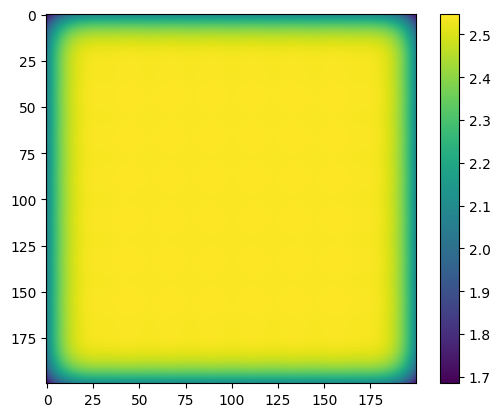


Ara veurem les funcions per generar les matrius d'incidència de cadascuna de les làmpades.

In [27]:
import numpy as np
import matplotlib.pylab as plt

#Funcions per generar la matriu de lampares amb perfil gaussia. La podeu ignorar
def gauss_centered(center,sig,N):
  x,y = np.meshgrid(np.arange(N),np.arange(N))
  M = np.exp(-1*((x-center[0])**2+(y-center[1])**2)/sig**2)
  return M


def generate_centroids(K,N):
  centroids = np.linspace(0,N,K)
  centroids = [[value,value_2] for value in centroids for value_2 in centroids]
  return centroids


def generate_lamp_array(N,K,sig,show = False):
  '''
  Aquesta funcio retorna una matriu de  K^2xNxN
  amb l'indcidencia de cada lampara en cadascun dels punts
  '''
  centroids = generate_centroids(K,N)
  M = [gauss_centered(center,sig,N) for center in centroids]
  if show:
    plt.scatter(np.array(centroids)[:,1],np.array(centroids)[:,0],marker = 'x')
    plt.imshow(np.array(M)[4])
    plt.xlim(-10,10+N)
    plt.ylim(-10,10+N)
  return np.array(M)

(9, 200, 200)


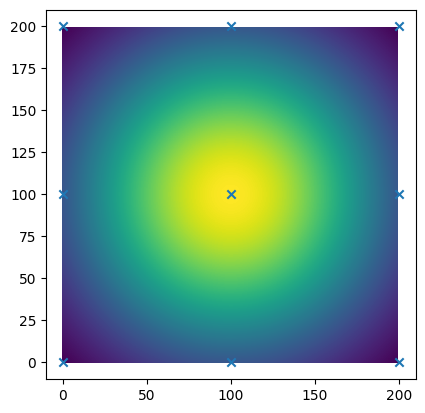

In [28]:
N = 200 #Tamany de l'area a controlar
K = 3 #Numero de lampares per eix
N_LAMPS = K**2 # EL numero de lampares total sera KxK
SIG  = 100 #sigma de la distribucio gausiana. Defineix com de difos es el perfil

LAMP_ARRAY = generate_lamp_array(N,K,SIG,show = True) #Retorna una matriu de  9x200x200 elements on  l'element  [i,:,:] es l'incidencia de la lampara i sobre l'area a controlar.
print (LAMP_ARRAY.shape)

La funció rellevant en relació amb les làmpades és la que es troba a la següent cel·la de codi. En aquesta funció, donat un array amb potències, ens retorna en forma de matriu 200x200 la potència total rebuda per cadascun dels punts.

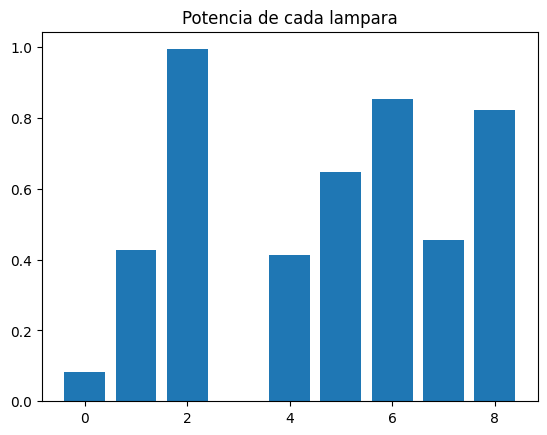

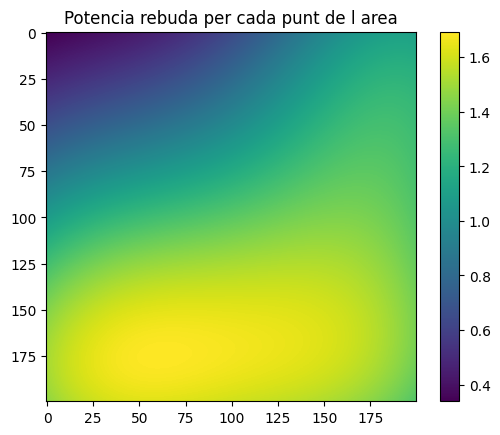

In [29]:
def get_applied_P(lamp_array,lamp_power):
  #Donat un array de potencies, retorna la potencia total que incideix sobre cada punt de l'area a controlar
  return (lamp_array.T*lamp_power).T.sum(axis = 0)

lamp_power = np.random.rand(N_LAMPS)
P = get_applied_P(LAMP_ARRAY, lamp_power)

plt.bar(np.arange(N_LAMPS),lamp_power)
plt.title('Potencia de cada lampara')
plt.show()

plt.imshow(P)
plt.colorbar()
plt.title('Potencia rebuda per cada punt de l area')
plt.show()

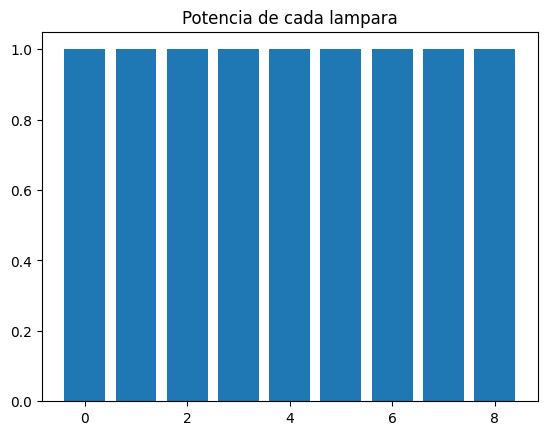

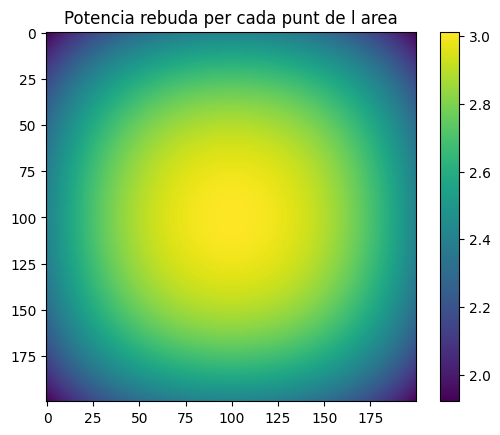

In [30]:
#Podem veure el perfil que resulta si cada lampara la fiquem a maxima potencia (potencia 1)
lamp_power = np.ones(N_LAMPS)
P = get_applied_P(LAMP_ARRAY, lamp_power)

plt.bar(np.arange(N_LAMPS),lamp_power)
plt.title('Potencia de cada lampara')
plt.show()
plt.imshow(P)
plt.colorbar()
plt.title('Potencia rebuda per cada punt de l area')
plt.show()

En la següent cel·la es declara la funció utilitzada per simular l'escalfament de l'àrea a controlar a causa de les làmpades i el refredament a causa de l'aire que circula per sobre de l'àrea.

Es mostra un exemple on, donada una temperatura de 100 graus i posant totes les làmpades a 0.3 durant 3 mil iteracions, s'arriba a una temperatura de 160 graus.

Ultima temperatura 159.30165100097656


Text(0, 0.5, 'temperatura')

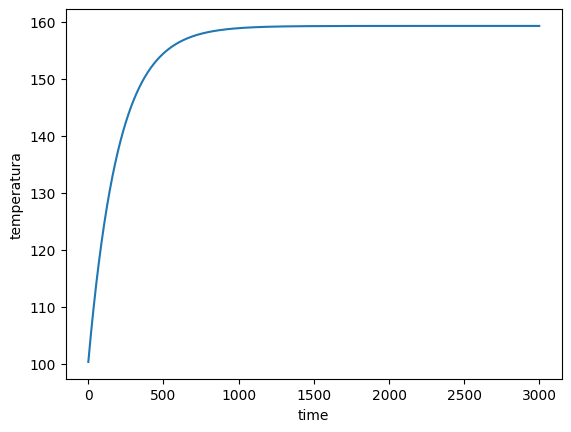

In [31]:
import cv2
import time

#CONSTANTS FISIQUES PER SIMULAR CALENTAMENT/REFREDAMENT

CONV_MAP = 1 #mapa de conveccio
CONV_COEF = 0.005 #Coeficient de conveccio. Com mes gran, mes rapid es refreda la superficie
CP = 0.1 # Coeficient que determina com de sensible es la temperatura a la potencia. A mes gran, mes sensible ets a la potencia.


def simulate_single_step(applied_P,conv_coef,T):
  T+=applied_P-conv_coef*T #Apliquem la potencia de les lampares y conveccio
  T = cv2.GaussianBlur(np.float32(T),(9,9),0) #Apliquem conduccio. Ho podeu ignorar
  return T

T = np.zeros((N,N))+100 #Iniciem la temperatura a 100 graus
lamp_power = np.ones(N_LAMPS)*0.3 #Fiquem les lampades a 0.3 unitats de potencia
P = get_applied_P(LAMP_ARRAY,lamp_power) #Potencia rebuda a cada punt

avg_T = [] #Guardem la temperatura promig a cada pas

STEPS = 3000
for i in range(STEPS):
  T = simulate_single_step(P,CONV_COEF,T)
  avg_T.append(np.mean(T))
print (f'Ultima temperatura {avg_T[-1]}')

plt.plot(avg_T)
plt.xlabel('time')
plt.ylabel('temperatura')


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 1.2 (0.25 punts):</strong>

 Per familiaritzar-te amb l'entorn, cerca a través de proves i errors quina potència hem de posar a les làmpades per aconseguir que la temperatura s'estabilitzi a 140 graus (aproximadament) partint d'una temperatura inicial de 100 graus. Utilitzeu 3000 iteracions com abans. Mostreu un gràfic amb l'evolució de la temperatura així com el perfil de temperatures que queda al final, per exemple, fent un imshow de la matriu de temperatura final.

Pista: Per simplificar, poseu totes les làmpades a la mateixa potència i utilitzeu el cas anterior, on si posàvem les làmpades a 0.3 s'arribava a 160 graus. Fent això hauríeu de tenir, més o menys, el següent perfil de temperatures/evolució de la temperatura:
</div>

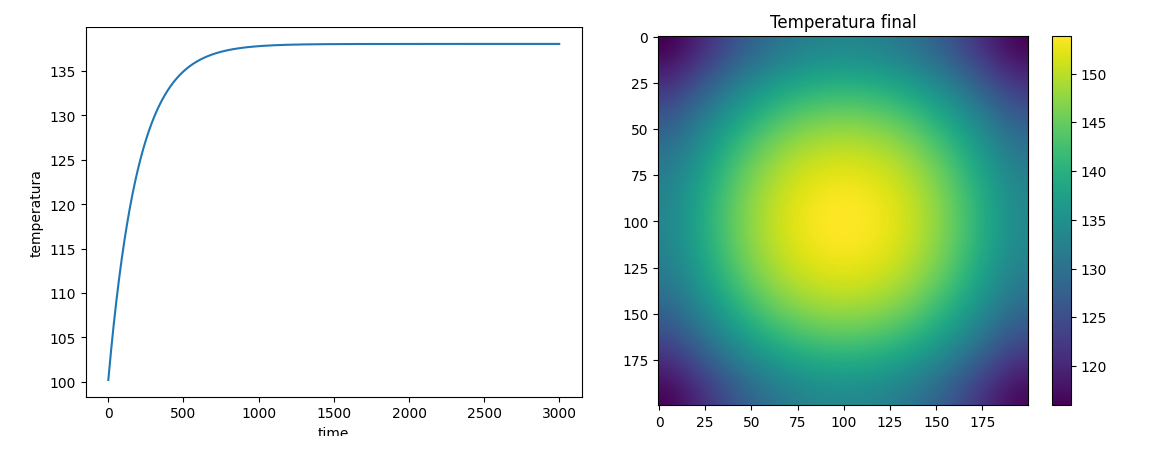

Ultima temperatura 138.06141662597656


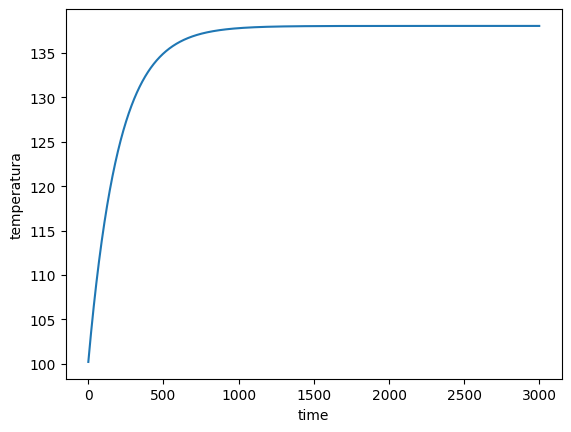

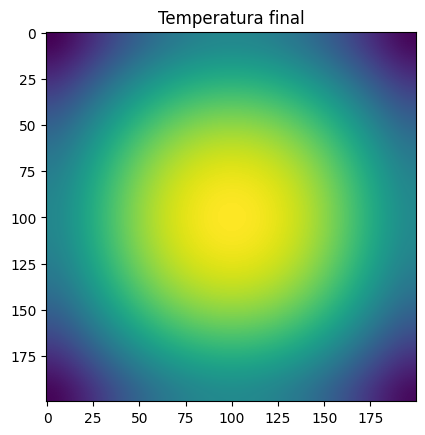

In [32]:
#CONSTANTS FISIQUES PER SIMULAR CALENTAMENT/REFREDAMENT

CONV_MAP = 1 #mapa de conveccio
CONV_COEF = 0.005 #Coeficient de conveccio. Com mes gran, mes rapid es refreda la superficie
CP = 0.1 # Coeficient que determina com de sensible es la temperatura a la potencia. A mes gran, mes sensible ets a la potencia.


def simulate_single_step(applied_P,conv_coef,T):
  T+=applied_P-conv_coef*T #Apliquem la potencia de les lampares y conveccio
  T = cv2.GaussianBlur(np.float32(T),(9,9),0) #Apliquem conduccio. Ho podeu ignorar
  return T

T = np.zeros((N,N))+100 #Iniciem la temperatura a 100 graus
lamp_power = np.ones(N_LAMPS)*0.26 #Fiquem les lampades a 0.26 unitats de potencia
P = get_applied_P(LAMP_ARRAY,lamp_power) #Potencia rebuda a cada punt

avg_T = [] #Guardem la temperatura promig a cada pas

STEPS = 3000
for i in range(STEPS):
  T = simulate_single_step(P,CONV_COEF,T)
  avg_T.append(np.mean(T))
print (f'Ultima temperatura {avg_T[-1]}')

plt.plot(avg_T)
plt.xlabel('time')
plt.ylabel('temperatura')
plt.show()

plt.imshow(T)
plt.title("Temperatura final")
plt.show()

## 2.Definició de l'entorn

Abans de començar amb el propi entorn, generarem els espais d'accions possibles a realitzar. Per poder provar els diferents algoritmes implementarem:

* Espais discrets:

  * Un espai d'accions on les accions siguin discretes i on totes les potències de les 9 làmpades es modifiquin alhora.

  * Un espai d'accions on les accions siguin discretes i on cada làmpada es modifiqui cada vegada.

  Per a aquests espais, l'acció 0 serà baixar la potència, l'acció 1 serà mantenir la potència i l'acció 2 serà pujar la potència.

* Un espai d'accions continu, on es generin 9 valors entre -1 i 1 que defineixin quina modificació en la potència volem fer.



In [33]:
import gymnasium as gym

class LampArrayPowerModifications_global(gym.spaces.Discrete):
  def __init__(self):
    super().__init__(3)
    self.action_to_string_map = {0:'decrease',1:'nothing',2:'increase'}
    self.name = 'global_discrete'

  def get_action_name(self,action):
    return self.action_to_string_map[action]

  def sample(self):
    action = super().sample()
    return action

actions = LampArrayPowerModifications_global()
actions.sample()

1

In [34]:
class LampArrayPowerModifications_discrete(gym.spaces.Discrete):
  #Les accions de l'1 al 18 corresponen a pujar/baixar les 9 lampares. De la 19-21 correspon a baixar, mantenir o pujar la potencia de totes a la vegada (com abans)
  def __init__(self,n_lamps):
    super().__init__(2*n_lamps+3)
    decrease_increase_map = {0:'decrease',
                             1:'increase'}
    decrease_increase_map_value = {0:0,
                             1:2}
    self.action_to_string_map = {i:f'lamp_{i//2+1}_{decrease_increase_map[i%2]}' for i in range(2*n_lamps)}
    self.action_to_tuple_map = {i:(i//2, decrease_increase_map_value[i%2]) for i in range(2*n_lamps)}

    self.n_lamps = n_lamps
    self.name = 'individual_discrete'

  def get_action_name(self,action):
    if action>=self.n_lamps*2:
      action -=self.n_lamps*2
      if action==0:
        string = 'decrease'
      elif action==1:
        string  = 'nothing'
      else:
        string = 'increase'

      return 'all_'+string
    else:
      return self.action_to_string_map[action]

  def get_action_array(self,action):
    #Donada una accio, retorna l'array amb la pujada de potencia
    if action>=self.n_lamps*2:
      # Si l'accio es una de les 3 globales (accions 19 20 i 21), retorna els numeros 0 1 o 2
      return action-self.n_lamps*2
    else:
      #Si no construeix un vector de 1's (recordeu que 1 = deixar las potencies iguals) on la lampada seleccionada prendrà valors 0 o 2 en funció de si augmenta o disminueix
      tuple_ = self.action_to_tuple_map[action]
      lamp_power = np.ones(self.n_lamps)
      lamp_power[tuple_[0]] = tuple_[1]
      return lamp_power

  def sample(self):
    action = super().sample()
    return action

actions = LampArrayPowerModifications_discrete(n_lamps = N_LAMPS)
for _ in range(10):
  sample = np.random.randint(N_LAMPS*2+3)
  print (actions.get_action_array(sample))
  print (actions.get_action_name(sample))
  print('\n\n')

[0. 1. 1. 1. 1. 1. 1. 1. 1.]
lamp_1_decrease



1
all_nothing



[1. 0. 1. 1. 1. 1. 1. 1. 1.]
lamp_2_decrease



[1. 0. 1. 1. 1. 1. 1. 1. 1.]
lamp_2_decrease



[1. 1. 2. 1. 1. 1. 1. 1. 1.]
lamp_3_increase



[1. 1. 1. 1. 1. 0. 1. 1. 1.]
lamp_6_decrease



[1. 1. 1. 1. 1. 1. 0. 1. 1.]
lamp_7_decrease



[1. 1. 1. 1. 1. 1. 1. 1. 0.]
lamp_9_decrease



[2. 1. 1. 1. 1. 1. 1. 1. 1.]
lamp_1_increase



[1. 2. 1. 1. 1. 1. 1. 1. 1.]
lamp_2_increase





In [35]:
class LampArrayPowerModifications_continious(gym.spaces.Box):
  #Genera un vector amb les modificacions de les potències de les lèmpades
  def __init__(self,n_lamps):
    super().__init__(low = np.array([-1]*n_lamps),high = np.array([1]*n_lamps))
    self.n_lamps = n_lamps
    self.name = 'individual_continious'


  def sample(self):
    action = super().sample()
    return action

actions = LampArrayPowerModifications_continious(n_lamps = N_LAMPS)
actions.sample()

array([-0.20917974, -0.40375826,  0.84292483,  0.37067786,  0.23811516,
       -0.56605077, -0.01786018,  0.348941  , -0.7123308 ], dtype=float32)

Abans de definir l'entorn, generarem una funció per calcular la recompensa que rep l'actor.

Què esperem d'aquesta funció?

* Rep com a paràmetres d'entrada la matriu de temperatura actual i un valor amb la temperatura objectiu.

* La recompensa ha de ser inversament proporcional a la diferència entre la temperatura actual i la temperatura objectiu.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 2.1 (0.75 punts):</strong>


Proposa 3 versions de la funció de recompensa dins de la funció <code>calculate_reward</code>. Explica les diferències entre elles i quina creus, a priori, que pot funcionar millor.

Genera també una funció que retorni els rangs de cada funció de recompensa (mínim, màxim) i implementa-ho dins de la funció <code>get_reward_range</code>. Aquesta última funció ens servirà per conèixer el rang de la recompensa dins de l'entorn.

Nota: de les 3 versions, se'n proporciona una ja implementada a mode d'exemple.
</div>

In [36]:
def calculate_reward(T,target_temp,method = 'method_1'):
  """
  - M1: fa servir la funció inversament proporcional a la diferència absoluta
    entre la temperatura actual i l'objectiu. Com més propera al target més
    recompensa.

  - M2: fa servir la funció exponencial, penalitzant les grans diferències de
    temperatura més que les altres. Com més propera al target més recompensa.
  """
  #Ha de retornar un únic valor de recompensa
  if method=='negative_error':
    #un exemple de funció d'error
    return np.mean(1+ -0.1*(T-target_temp)**2)
  elif method=='method_1':
    return np.mean(1 / (1 + np.abs(T - target_temp)))
  elif method=='method_2':
    return np.mean(np.exp(-0.1 * np.abs(T - target_temp)))
  else:
    return np.mean(1 / (1 + np.abs(T - target_temp)))

In [37]:
def get_reward_range(method = 'method_1'):
  #Ha de retornar una tupla (min,max)
  if method=='negative_error' :
    #Per exemple, si el reward pot anar de -inf a inf retornem (-1*np.inf,np.inf)
    return (-1*np.inf,1)
  elif method=='method_1':
    return (0,1)
  elif method=='method_2':
    return (0,1) #Sempre positiu per el exponencial
  else:
    return (0,1)

Ara definirem les diferents observacions possibles. Hi ha diverses opcions diferents per a l'espai d'observacions:

 * Temperature mode ('average'/'lamp' o 'image') : Si és 'average', torna la temperatura mitjana. Si és 'image' retorna la temperatura a cada punt (array de 40 mil valors). Si és 'lamp' subdivideix l'espai en una matriu de 3x3 i torna 9 temperatures.

 * Normalize temperature (True/False): Si és True, normalitza les temperatures dividint-les pel target. Si és false, torna les temperatures sense modificar i afegeix el target a l'array de tempertures.

 * Return power (True/False): Si es torna o no la potència de les làmpades com a observació.

 * Power mode ('average'/'lamp'): Si és 'average' es torna la potència mitjana. Si és 'lamp', es tornen les 9 potènies.

* Buffer size (int): La mida del buffer d'imatges de temperatura que volem donar com a observacio. Sempre ha de ser >2.

Fixeu-vos que totes aquestes opcions són al final hiperparametres amb els que podreu jugar quan entreneu la vostra DQN més endavant.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 2.2 (0.25 punts):</strong>

Completa els comentaris de la classe <code>TemperatureEnvObservation</code> explicant que fa cadascuna de les parts. Cal completar els comentaris amb <code>#TODO: Comentar</code>

</div>

In [38]:
class TemperatureEnvObservation():

  def __init__(self,
               temperature_mode = 'average',
               normalize_temperature = False,
               return_power = True,
               power_mode= 'average',
               buffer_size = 3):

    assert(buffer_size>=2) # Assegurem que la mida del buffer és suficient per calcular la mitjana de les observacions
    self.temperature_mode = temperature_mode
    self.buffer_size = buffer_size
    self.normalize_temperature = normalize_temperature

    self.power_mode = power_mode
    self.return_power = return_power

  def get_observation(self,temperature_image_buffer,lamp_power,target):

    #################################
    #Observacions de la temperatura#
    #################################

    if self.temperature_mode == 'average': # Aquesta opció calcula la mitjana de les observacions
      temperature_buffer = np.mean(temperature_image_buffer,axis = -1).mean(axis=-1)

    elif self.temperature_mode =='lamp': # Aquesta opció agrega les dades de temperatura en un array de 3x3, redimensionant l'espai a 9 temperatures.
      temperature_buffer = np.array([cv2.resize(temp,dsize= (K,K)).reshape(-1) for temp in temperature_image_buffer]).reshape(-1)

    elif self.temperature_mode=='image': # Es guarda una còpia de la temperatura de tots els punts de l'espai
      temperature_buffer = np.copy(temperature_image_buffer)

    # Si s'indica que es vol normalitzar, es divideix la temperatura per la mitjana del target (fent que la temperatura siga ara relativa a la mitjana del target)
    if self.normalize_temperature:
      temperature_buffer = (temperature_buffer/np.mean(target)).tolist()
    else:
      temperature_buffer = temperature_buffer.tolist()+[np.mean(target)]

    ##############################
    # Observacions de la potencia#
    ##############################

    power = []
    if self.return_power: # Si es vol que es retorne la potència de les lampares:
      if self.power_mode=='average': # Es retorna la mitjana de la potència de les lampares per a aquesta opció
        power =  [np.mean(lamp_power)]
      elif self.power_mode =='lamp': # Es retorna la potència de cada lampara.
        power =  lamp_power.tolist()

    # L'observació retorna la temperatura amb la potència de les lampares (Si s'ha demanat)
    return np.array(temperature_buffer+power)

  def get_observation_space(self):
    #Observacions de la temperatura
    lows = []
    highs = []
    if self.temperature_mode == 'average':
      lows += [-np.inf]*self.buffer_size
      highs += [np.inf]*self.buffer_size

    elif self.temperature_mode =='lamp':
      lows += [-np.inf]*self.buffer_size*K**2
      highs += [np.inf]*self.buffer_size*K**2

    elif self.temperature_mode=='image':
      raise NotImplementedError('Image method not implemented')
      temperature_buffer = np.copy(temperature_image_buffer)

    if not self.normalize_temperature:
      lows += [-np.inf]
      highs += [np.inf]

    #Observacions de la potencia
    power = []
    if self.return_power:
      if self.power_mode=='average':
        lows += [0]
        highs += [1]
      elif self.power_mode =='lamp':
        lows += [0]*K**2
        highs += [1]*K**2

    #Retornem tot
    return gym.spaces.Box(low = np.array(lows), high = np.array(highs))


Ara anem a definir l'entorn. Això ja ho heu practicat en altres PECS, així que en aquest cas l'entorn ja es dóna totalment definit.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 2.3 (0.5 punts):</strong>

Completa els comentaris de la classe <code>TemperatureEnv</code> explicant que fa cadascuna de les parts. Cal completar els comentaris amb <code>#TODO: Comentar</code>

</div>

In [39]:
import numpy as np
class TemperatureEnv(gym.Env):
  def __init__(self,
                N, #Mida de l'àrea a controlar
                K, #Nombre de làmpades per eix
                sigma, #Desviació estàndard de les làmpades
                To, #Temperatura inicial
                conv_coef, #Coeficient de convecció
                actions, #Espai d'accions
                observation: TemperatureEnvObservation(), #Objecte amb les observacions
                reward_method: str, #Tipus de recompensa triat entre les opcions que heu programat.
                lamp_increase = 0.05, #Increment de la làmpada en cas de l'espai discret
                target_range = (100,160), #Rang en què pot variar el target.
                max_steps = 600, #Nombre màxim de passos abans de truncar cada episodi
                iterations_per_action = 5, #Cada vegada que es realitza una acció, quantes vegades es deixa evolucionar l'entorn abans de deixar prendre la següent acció.
                is_eval = False #Flag per saber si l'entorn s'utilitza per avaluar o no. Si és True, l'entorn utilitza una temperatura constant cada vegada que es fa el reset (no utilitza el target range)
               ):

    self.N = N
    self.n_lamps_per_direction = K
    self.n_lamps = K**2

    self.To = To #Temperatura inicial amb la qual comencem
    self.conv_coef = conv_coef #Coeficient de convecció
    self.sigma = sigma #Ample de l'efecte de la làmpada

    self.lamp_increase = lamp_increase #Increment de la làmpada en cas de l'espai discret
    self.max_steps = max_steps #Nombre màxim de passos per aconseguir la temperatura target
    self.target_range = target_range #Rang de temperatures del target

    self.lamp_array = self.load_lamps_map() #Carreguem l'array de làmpades

    self.action_space = actions #Accions a prendre

    self.observation = observation #Nombre d'observacions a fer

    self.iterations_per_action = iterations_per_action #Nombre d'iteracions per acció



    # En el cas d'escollir l'espai d'accions discretes, es transforma l'espai d'accions segons com es definisca l'entorn
    if self.action_space.name =='individual_discrete':
      self.modify_action = lambda x: self.action_space.get_action_array(x)
    else:
      self.modify_action = lambda x: x

    # Es comprova si l'espai d'accions és continu per operar després com corresponga
    self.is_continious = False
    if 'continious' in self.action_space.name:
      self.is_continious = True

    self.reward_range = get_reward_range(reward_method) #Rang del reward
    self.observation_space = self.observation.get_observation_space() #Espai d'observacions

    self.reward_method = reward_method
    self.is_eval = is_eval
    self.reset()


  def step(self,action):
    # Per prendre l'step, es comprova primer com està definit l'espai d'accions, si continu o discret, i s'agafa una acció
    if self.is_continious:
      self.lamp_power+=action
    else:
      action = self.modify_action(action)
      self.lamp_power+=self.lamp_increase*(action-1)

    # Comprova que el power de la lampara està en el rang permés [0,1]
    self.lamp_power = np.clip(self.lamp_power,0,1)

    #Simulem que deixem les làmpades a la nova potencia durant self.iterations_per_actions
    for _ in range (self.iterations_per_action):
      self.simulate() #evoluciona la temperatura


    #truncar si s'arriba al limit d'steps
    if self.current_time >= self.max_steps:
      truncated = True
    else:
      truncated = False

    #Calculem el reward
    reward = self.get_reward()

    # S'actualitza el buffer de temperatures
    self.temperature_buffer.append(self.temperature)
    del self.temperature_buffer[0]

    #Calculem l'observacio
    obs = self.get_observation()

    # Es computa la informació de cada step
    info = {'avg_temperature':self.temperature.mean(),
            'target_temperature':self.target.mean(),
            'avg_power':self.lamp_power.mean(),
            'reward':reward,
            'time':self.current_time,
            'max_time':self.max_steps}

    return obs,reward,False,truncated,info

  def get_observation(self):
    return self.observation.get_observation(self.temperature_buffer,self.lamp_power,self.target)

  def get_reward(self):
    return calculate_reward(self.temperature,self.target.mean(),self.reward_method)


  def simulate(self):
    #Calcular la potencia aplicada i simular l'evolucio de la temperatura
    applied_P = get_applied_P(self.lamp_array,self.lamp_power)
    self.temperature = simulate_single_step(applied_P,
                         self.conv_coef,
                         self.temperature)
    self.temperature[self.temperature<0] = 0

    #Sumar 1 al temps passat
    self.current_time += 1

  def init_power_array(self):
    #Iniciem les lampares a potencia = 0
    return np.zeros(self.n_lamps)

  def load_lamps_map(self):
    #Generar el mapa de lampares
    return generate_lamp_array(self.N,self.n_lamps_per_direction,self.sigma)

  def init_temperature(self):
    #Iniciem temperatura a To
    return np.zeros((N,N))+self.To

  def generate_random_target(self):
    #Generem matriu de temperatures target de forma random
    if self.is_eval:
      current_target_temp = np.mean(self.target_range) # Si el model s'està evaluant, agafa la temperatura mitjana del rang proporcionat com a objectiu
    else:
      #Si l'entorn no es d'evaluacio, selecciona la temperatura target de forma random.
      current_target_temp = np.random.choice(np.arange(self.target_range[0],self.target_range[1],0.5))

    return np.ones(shape = (self.N,self.N))*current_target_temp


  def reset(self,seed = None):
    self.lamp_power = self.init_power_array() #Reset potencia de les lampares
    self.temperature = self.init_temperature() #Reset temperatura
    self.current_time = 0 #Reset temps
    self.target = self.generate_random_target() #Resetear target
    self.temperature_buffer = [self.temperature]*self.observation.buffer_size # Es reseteja el buffer de temperatura segons la grandària proporcionada
    return self.get_observation(),{}

Ara testejarem que l'entorn funciona. Posem una temperatura inicial de 80 graus, un lamp_increase de 0.05 i fem servir les modificacions globals de la potència. Per a la funcio de reward, farem servir la que se us ha donat per defecte.

Desarem la informació que ens torna l'entorn en una llista.

In [40]:
To = 80 #Temperatura inicial

actions = LampArrayPowerModifications_global()
observation_space = TemperatureEnvObservation()
env = TemperatureEnv(N,
               K,
               SIG,
               To,
               CONV_COEF,
               actions,
               observation_space,
               reward_method = 'negative_error')


obs, _ = env.reset()
info_history = []
for i in range(500):
  action = env.action_space.sample()
  obs, reward, terminated,truncated, info = env.step(int(action))
  info_history.append(info) #Guardem l'informacio de l'entorn en una llista

  if truncated or terminated:
    break

for i in info_history:
  print(i)

{'avg_temperature': 78.019905, 'target_temperature': 116.5, 'avg_power': 0.0, 'reward': -147.07176, 'time': 5, 'max_time': 600}
{'avg_temperature': 76.08882, 'target_temperature': 116.5, 'avg_power': 0.0, 'reward': -162.30624, 'time': 10, 'max_time': 600}
{'avg_temperature': 74.862335, 'target_temperature': 116.5, 'avg_power': 0.05, 'reward': -172.36987, 'time': 15, 'max_time': 600}
{'avg_temperature': 74.32304, 'target_temperature': 116.5, 'avg_power': 0.1, 'reward': -176.89255, 'time': 20, 'max_time': 600}
{'avg_temperature': 74.45396, 'target_temperature': 116.5, 'avg_power': 0.15000000000000002, 'reward': -175.7984, 'time': 25, 'max_time': 600}
{'avg_temperature': 73.924934, 'target_temperature': 116.5, 'avg_power': 0.10000000000000002, 'reward': -180.28308, 'time': 30, 'max_time': 600}
{'avg_temperature': 73.40905, 'target_temperature': 116.5, 'avg_power': 0.10000000000000002, 'reward': -184.7124, 'time': 35, 'max_time': 600}
{'avg_temperature': 72.905945, 'target_temperature': 11

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 2.4 (0.25) punts:</strong>

Imprimiu l'informacion que retorna l'entorn. Descriviu breument el que es retorna

</div>

**Comentari:**
Ens retorna els valors de informació de cada step guardats a la llista info.
Com l'elecció és aleatòria (.sample()), no n'hi ha molt a comentar i l'execució acaba quan s'aplega al temps màxim de l'episodi. S'hi veu que es va modificant la potència de les lampares aleatòriament (variant lleugerament la temperatura) i que el reward és sempre negatiu.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 2.5 (0.5) punts:</strong>

Completa la funció <code> analyze_run </code> on, donada la llista d'informació <code>info_hist</code>, es mostri:

* L'evolució de la temperatura mitjana, amb l'objectiu com a línia de referència.
* L'evolució de la potència mitjana al llarg del temps.
* L'evolució de les recompenses al llarg del temps.

Executa-la per al cas anterior.
</div>


In [41]:
def analyze_run(info_hist):
    # Extracció de dades per a l'anàlisi
    avg_temperature = [info['avg_temperature'] for info in info_hist]
    target_temperature = [info['target_temperature'] for _ in info_hist]
    avg_power = [info['avg_power'] for info in info_hist]
    rewards = [info['reward'] for info in info_hist]
    time_steps = range(len(info_hist))

    # Gràfic de l'evolució de la temperatura mitjana amb l'objectiu com a línia de referència
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, avg_temperature, label='Avg Temp')
    plt.plot(time_steps, target_temperature, '--', label='Target Temp')
    plt.xlabel('Time Steps')
    plt.ylabel('Temp')
    plt.title('Evolució de la temperatura mitjana')
    plt.legend()
    plt.show()

    # Gràfic de l'evolució de la potència mitjana al llarg del temps
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, avg_power, label='Avg Power')
    plt.xlabel('Time Steps')
    plt.ylabel('Power')
    plt.title('Evolució de la potència mitjana')
    plt.legend()
    plt.show()

    # Gràfic de l'evolució de les recompenses al llarg del temps
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, rewards, label='Rewards')
    plt.xlabel('Time Steps')
    plt.ylabel('Reward')
    plt.title('Evolució de les recompenses')
    plt.legend()
    plt.show()

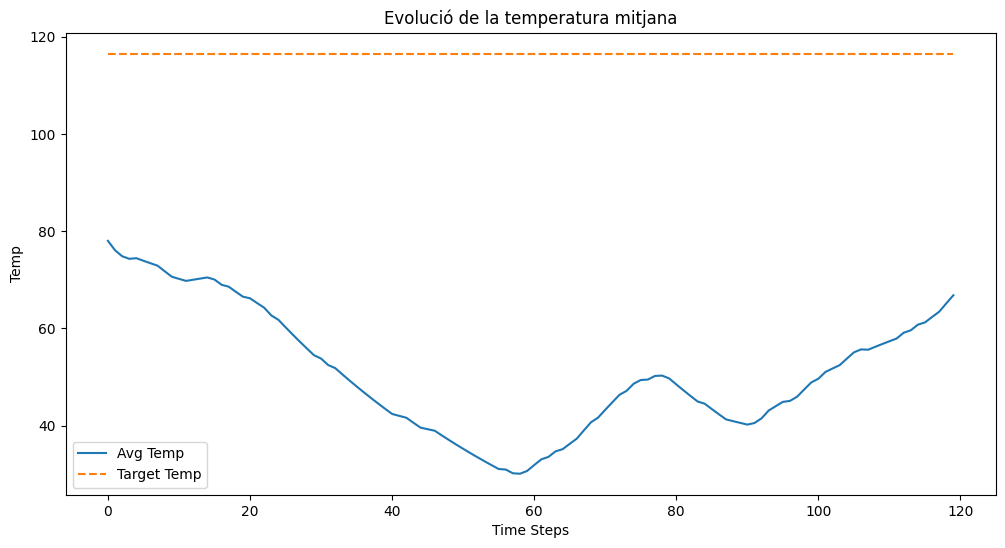

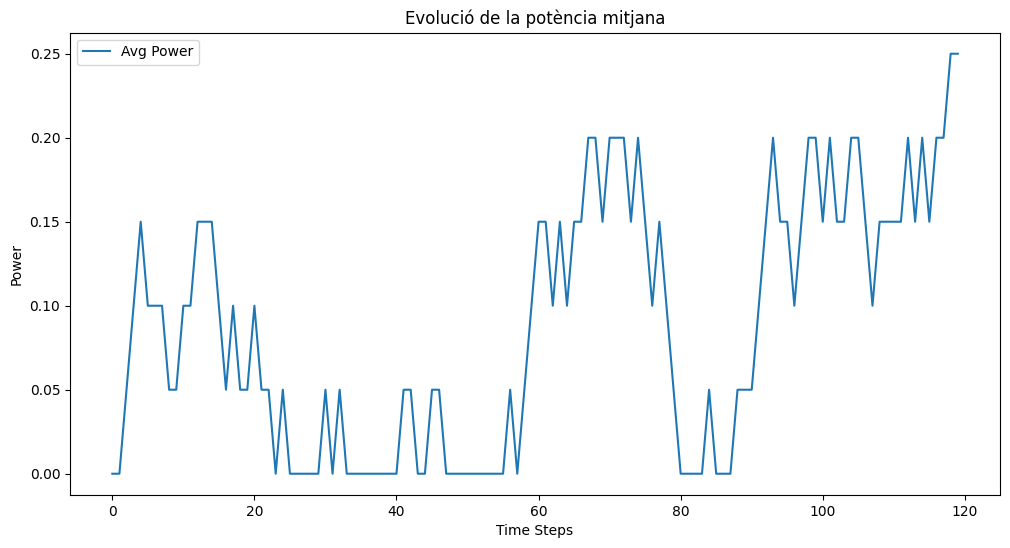

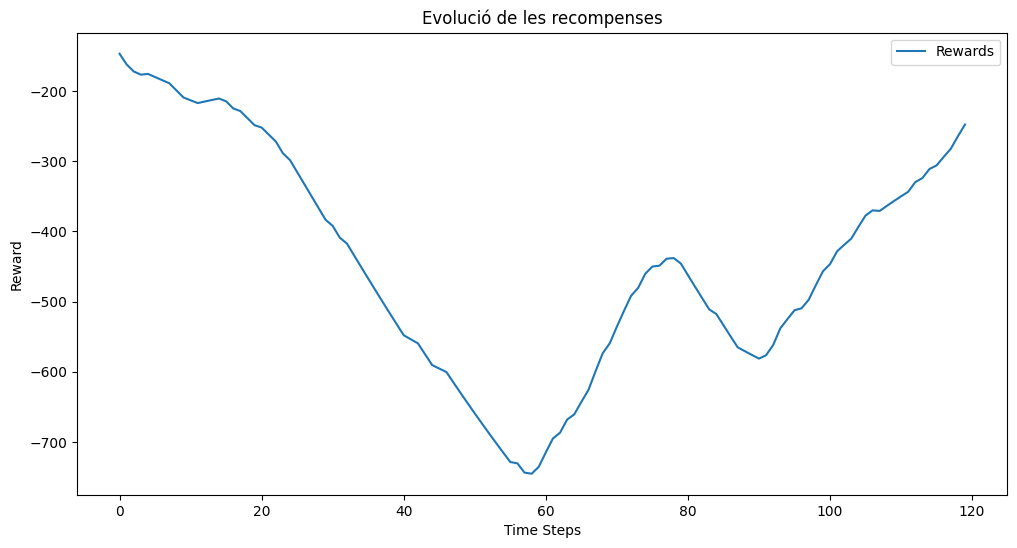

In [42]:
#Ara l'executem per al cas anterior
analyze_run(info_history)

## 3. Entrenament de l'agent

Ara entrenarem una DQN i buscarem els millors hiperparàmetres. Per fer-ho, com ja s'ha dit, farem servir la llibreria stable-baselines3.

In [43]:
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback

Abans de comencar amb l'Exercici, llegiu la documentacio de [DQN](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html) y de [EvalCallback](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html) dins de stable-baselines3.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 3.1 (2.5 punts):</strong>

Aquest exercici es divideix en 2 parts que cal fer de forma simultània.

<strong>Exercici 3.1.1 (2 punts):</strong>

Crea un model DQN amb una 'MlpPolicy' per resoldre el problema de control de temperatura fent servir com a espai d'accions les accions globals (LampArrayPowerModifications_global). Cal trobar els millors hiperparàmetres entre:

*   learning_starts
*   target_update_interval
*   learning_rate
*   Funció de recompensa
*   exploration_factor

Hi ha molts hiperparàmetres a buscar. Alguns d'ells (buffer size, tipologia d'observació, funció de recompensa...) es poden triar sense necessitat d'entrenar el model. Altres com learning_starts, target_update_interval o learning_rate requereixen provar diferents valors i observar com millora la funció d'error. <strong>IMPORTANT: No és necessari fer més de 40 mil iteracions d'entrenament.</strong>

<strong>Exercici 3.1.2 (0.5 punts):</strong>
Un problema amb el qual us podeu trobar durant l'execució és que l'entrenament és inestable. Una forma de tractar-ho és fer servir l'EvalCallback. Això ens permet avaluar el model de forma periòdica i, en cas que sigui el millor model fins al moment, guardar el model entrenat en un zip. Això ens permet, posteriorment, carregar el millor model vist durant l'entrenament i fer-ne ús. Feu servir aquest callback per anar guardant el model durant l'entrenament.

</div>


In [96]:
learning_starts_values = [250]
target_update_interval_values = [70]
learning_rate_values = [0.01]
buffer_size_values = [1000]
exploration_fraction_values = [0.1]

resultats_grid_search = []

# 'negative_error', 'method_1', 'method_2'

for learning_starts in learning_starts_values:
    for target_update_interval in target_update_interval_values:
        for learning_rate in learning_rate_values:
            for buffer_size in buffer_size_values:
                for exploration_fraction in exploration_fraction_values:
                  actions = LampArrayPowerModifications_global()
                  observation_space = TemperatureEnvObservation()
                  reward_method = 'negative_error'
                  env = TemperatureEnv(N,
                                K,
                                SIG,
                                To,
                                CONV_COEF,
                                actions,
                                observation_space,
                                reward_method = reward_method)

                  #Creem un entorn per l'evaluacio del callback.
                  #Aquest entorn te sempre el mateix target per tal que el EvalCallback no depengui del target random de l'entorn
                  env_eval = TemperatureEnv(N,
                                K,
                                SIG,
                                To,
                                CONV_COEF,
                                actions,
                                observation_space,
                                reward_method = reward_method,
                                is_eval = True)

                  model = DQN("MlpPolicy",
                              env,
                              learning_starts = learning_starts,
                              target_update_interval = target_update_interval,
                              learning_rate = learning_rate,
                              buffer_size = buffer_size,
                              exploration_fraction = exploration_fraction,
                              tensorboard_log  = './logs')



                  callback = EvalCallback(eval_env = env_eval,
                                          eval_freq = 500,
                                          best_model_save_path = './')

                  initial_eval = evaluate_policy(model,env_eval,n_eval_episodes = 5,deterministic = True)
                  model.learn(total_timesteps= 4000,
                              callback = callback,
                              progress_bar = True)
                  final_eval = evaluate_policy(model,env_eval,n_eval_episodes = 5,deterministic = True)

                  # Emmagatzemar els resultats
                  resultats_grid_search.append({
                      'learning_starts': learning_starts,
                      'target_update_interval': target_update_interval,
                      'learning_rate': learning_rate,
                      'buffer_size': buffer_size,
                      'exploration_fraction': exploration_fraction,
                      'initial_eval': initial_eval,
                      'final_eval': final_eval
                  })

for result in resultats_grid_search:
    print(f"Paràmetres: {result['learning_starts']}, {result['target_update_interval']}, {result['learning_rate']}, {result['buffer_size']}, {result['exploration_fraction']}")
    print(f"Initial Evaluation: {result['initial_eval']}")
    print(f"Final Evaluation: {result['final_eval']}")
    print("\n")

Output()

Eval num_timesteps=500, episode_reward=-95046.24 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=1000, episode_reward=-52143.97 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=1500, episode_reward=-33351.02 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=2000, episode_reward=-9494.37 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=2500, episode_reward=-301291.46 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=3000, episode_reward=-5497.82 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=3500, episode_reward=-5069.91 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=4000, episode_reward=-4907.36 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Paràmetres: 250, 70, 0.01, 1000, 0.1
Initial Evaluation: (-137193.86471557617, 0.0)
Final Evaluation: (-4998.706020832062, 0.0)




Proves fetes amb grid search per al mètode escollit de recompensa (he fet moltes més, mostre les millors):

Paràmetres: 1000, 300, 0.01, 20000, 0.1
Initial Evaluation: (-137193.86471557617, 0.0)
Final Evaluation: (-3041.3095297813416, 0.0)

Paràmetres: 1000, 500, 0.01, 30000, 0.1
Initial Evaluation: (-102646.02856445312, 0.0)
Final Evaluation: (-3023.9302303791046, 0.0)

Paràmetres: 1000, 800, 0.01, 20000, 0.1
Initial Evaluation: (-137193.86471557617, 0.0)
Final Evaluation: (-3013.2849764823914, 0.0)

Paràmetres: 2000, 800, 0.01, 20000, 0.1
Initial Evaluation: (-818280.38301754, 0.0)
Final Evaluation: (-3099.0719418525696, 0.0)


Paràmetres: 1000, 700, 0.01, 10000, 0.1
Initial Evaluation: (-818280.38301754, 0.0)
Final Evaluation: (-3050.487966299057, 0.0)

Paràmetres: 1000, 700, 0.01, 10000, 0.4
Initial Evaluation: (-137193.86471557617, 0.0)
Final Evaluation: (-2980.287845849991, 0.0)

Paràmetres: 1000, 700, 0.03, 10000, 0.25
Initial Evaluation: (-818280.38301754, 0.0)
Final Evaluation: (-3015.7519085407257, 0.0)

Paràmetres: 1000, 700, 0.005, 10000, 0.1
Initial Evaluation: (-137193.86471557617, 0.0)
Final Evaluation: (-3006.9922540187836, 0.0)


Paràmetres: 1000, 700, 0.005, 10000, 0.25
Initial Evaluation: (-137193.86471557617, 0.0)
Final Evaluation: (-2987.5448796749115, 0.0)


Paràmetres: 1000, 700, 0.005, 10000, 0.4
Initial Evaluation: (-137193.86471557617, 0.0)
Final Evaluation: (-3090.7745356559753, 0.0)

////////////////////////////////////////////////////////////////////////////////

Nota: aquest exercici s'havia aproximat a partir d'assumir que les màximes iteracions possibles eren 40000. Per tant tots els tests que n'hi ha dalt funcionaven amb 40000 iteracions, amb 5000 de callback. Al llegir l'enunciat seguent, 3.3, he interpretat que havia d'intentar aconseguir l'entrenament més senzill/curt, no el millor.

El millor entrenament, de tots els paràmetres que he provat a dalt, per a mi ha sigut el de 1000, 700, 0.01, 10000, 0.2 amb 40000 iteracions i 5000 de callback (tardava uns 6/7 minuts en entrenar). En lloc de multiplicar els valors al seguent exercici, faré el seguent amb aquests i en el actual els he dividit per 10. A partir d'ací he intentat trobar una solució aproximada també optima, en un període d'entrenament curt.

Millors paràmetres per a temps d'execució: 300, 70, 0.01, 1000, 0.1, 4000 iteracions i 500 de callback

In [97]:
print(f'Initial evaltuation {initial_eval}')
print(f'Final evaltuation {final_eval}')

Initial evaltuation (-137193.86471557617, 0.0)
Final evaltuation (-4998.706020832062, 0.0)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 3.2 (0.5 punts):</strong>

Un cop trobats els millors hiperparàmetres, entreneu amb aquests i carregueu el millor model (fent servir la funció [load](https://stable-baselines3.readthedocs.io/en/master/guide/save_format.html) ).  Fent servir la funció analyze_run generada anteriorment, analitzeu i comenteu els resultats d'una execució aleatòria.
</div>

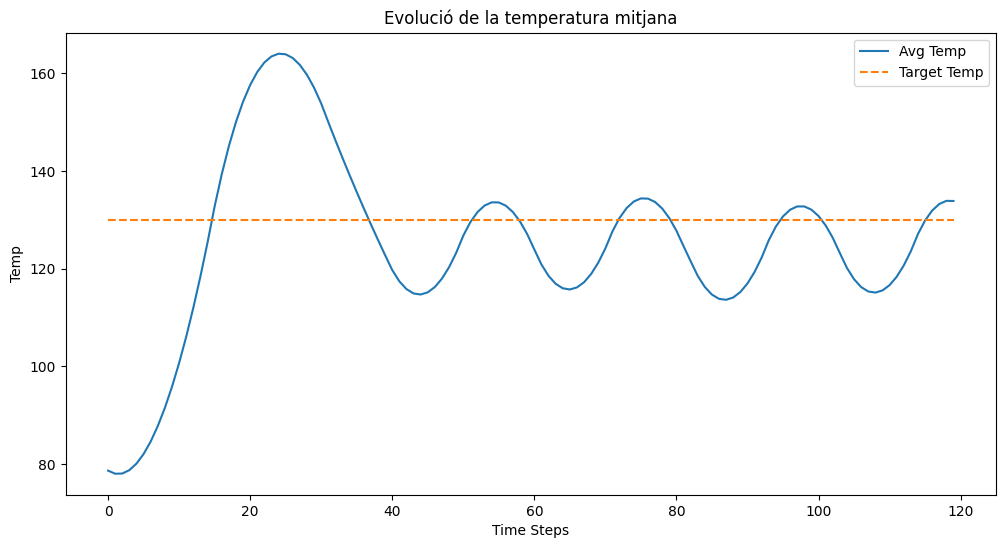

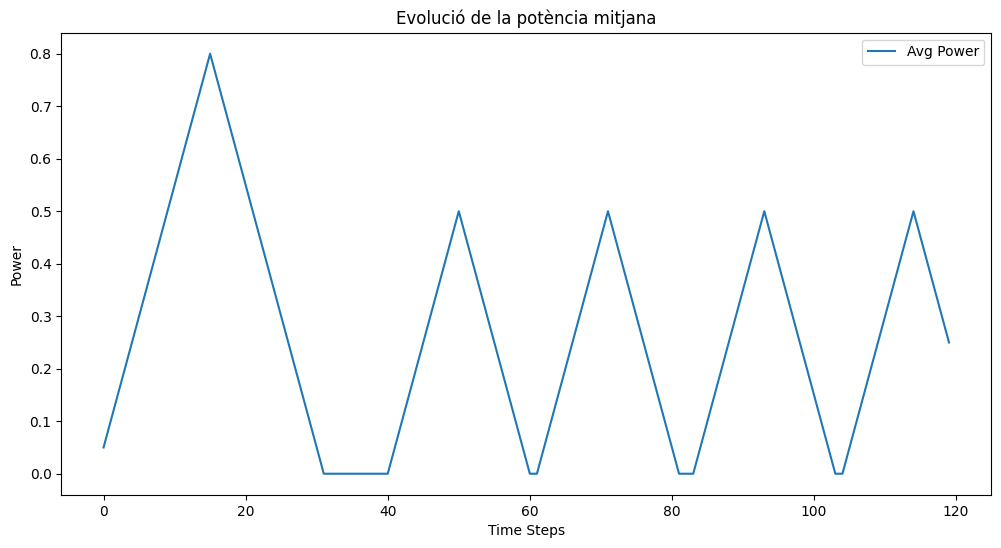

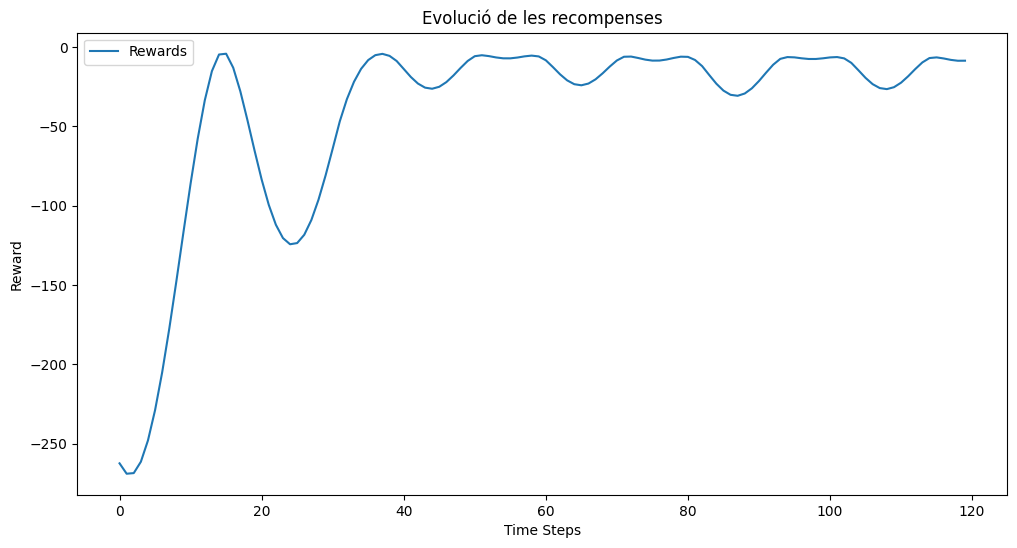

Temperatura final: 133.87532
Desviació estàndard: 8.98894


In [98]:
model = DQN.load('./best_model.zip')
obs, _ = env_eval.reset() #Reset entorn
info_history = []
while True:
  action, _ = model.predict(obs, deterministic=True)  # Prediu l'acció amb el model carregat
  obs, reward, terminated, truncated, info = env_eval.step(action)
  info_history.append(info)  # Guarda la informació # Guarda la informació

  if truncated or terminated:
    break

analyze_run(info_history)
final_temperature  = env_eval.temperature
print("Temperatura final:", np.mean(final_temperature))
print("Desviació estàndard:", np.std(final_temperature))

Amb els paràmetres actuals no s'aconsegueix la millor execució, com s'ha comentat prèviament, però garanteix que l'agent aprenga a gestionar la temperatura de l'entorn. S'hi veu com la temperatura s'ajusta rapidament al target demanat i oscila poc a poc al voltant d'aquest.

Si ens fixem en la potència de les làmpares, s'hi veu que té el problema d'aplicar ajustos molt bruscos als seus valors. Per tant sobrecalenta l'ambient i quan se'n passa, redueix molt la potència i el refreda fins que cau de la temperatura target i repeteix el procés.

Al gràfic de recompenses s'hi pot veure que s'incrementa rapidament el seu nombre fins que inicialment l'agent se'n passa molt de la temperatura target i cauen. Una vegada s'ajusta, però, l'agent oscil·la al voltant del target i les recompenses s'ajusten segons la temperatura s'allunye del target o no.

Ja dic, no és igual d'eficient que el model provat amb els altres hiperparàmetres, ja que era molt més estable, però presenta un comportament semblant en un menor temps d'entrenament.

S'hi veu que la temperatura final és 133.8, amb una desviació estandar de +-8.9 graus al final de l'execució.

Nota: he vist que amb agents entrenats amb poques iteracions n'hi ha més variabiltiat dels resultats que amb els que s'entrenen amb més iteracions. És a dir, per a l'algorisme presentat no sempre dona els mateixos resultats cada vegada que l'entrenes. En canvi aquesta variabilitat no s'ha trobat (tant) amb els millors hiperparàmetres comentats anteriorment.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 3.3 (2 punts):</strong>

Repeteix el que s'ha mencionat anteriorment però ara fent servir l'espai d'accions LampArrayPowerModifications_discrete.

En lloc de buscar els millors hiperparàmetres, fes servir els mateixos paràmetres que els anteriors, llevat dels paràmetres: learning_starts, total_timesteps, target_update_interval, buffer_size i eval_frequency que simplement els podeu multiplicar per un factor de 10.

Un punt molt important per a aquest cas és modificar adequadament l'espai d'observacions. No cerqueu valors d'hiperparàmetres de la DQN, però jugueu amb els diferents tipus d'observacions.

Comenta com són els resultats trobats així com quines són les diferències tant en resultats com en temps d'entrenament respecte al cas anterior. Creus que és bo fer servir un espai d'accions discret tan gran? Quina creus que és la solució?

Important: No espereu trobar resultats molt millors (o simplement millors) que a l'apartat anterior.
</div>

In [120]:
To = 80 #Temperatura inicial

# temperature_mode = 'average', 'lamp', 'image'       (image no és realista intentar entrenar-lo, a més n'hi ha un raiseNotImplementedError. Average no pot ser perquè demana després la potència de les lampares i és valor per defecte, és a dir s'ha fet al 3.2)
# power_mode = 'average', 'lamp'                      (Depen de return power. Demana la potència de les lampares després. El average és el per defecte)
# normalize_temperature = True / False                (Normalitza segons target. False és el per defecte)
# return_power = True / False                         (Sols és interessant si és true. Ha de ser true pel que es diu després)
# buffer_size = Numeric                               (hauria de ser poc perquè es fan mitjanes)

actions = LampArrayPowerModifications_discrete(N_LAMPS)
observation_space = TemperatureEnvObservation(temperature_mode='lamp',
                                              power_mode = 'lamp',
                                              normalize_temperature= True,
                                              return_power = True,
                                              buffer_size = 2)

reward_method = 'negative_error'
env = TemperatureEnv(N,
               K,
               SIG,
               To,
               CONV_COEF,
               actions,
               observation_space,
               reward_method = reward_method)

env_eval = TemperatureEnv(N,
               K,
               SIG,
               To,
               CONV_COEF,
               actions,
               observation_space,
               reward_method = reward_method,
               is_eval = True)

model = DQN("MlpPolicy",
            env,
            learning_starts = 1000,
            target_update_interval = 700,
            learning_rate = 0.01,
            buffer_size = 10000,
            exploration_fraction = 0.2,
            tensorboard_log  = './logs')



callback = EvalCallback(eval_env = env_eval,
                        eval_freq = 5000,
                        best_model_save_path = './best1')

initial_eval = evaluate_policy(model,env_eval,n_eval_episodes = 5,deterministic = True)
model.learn(total_timesteps= 40000,
            callback = callback,
            progress_bar = True)
final_eval = evaluate_policy(model,env_eval,n_eval_episodes = 5,deterministic = True)

Output()

Eval num_timesteps=5000, episode_reward=-477033.82 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-92338.86 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=15000, episode_reward=-92004.22 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=20000, episode_reward=-29866.88 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=25000, episode_reward=-16058.92 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=30000, episode_reward=-9004.98 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=35000, episode_reward=-10714.79 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-24581.35 +/- 0.00

Episode length: 120.00 +/- 0.00

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

Carregueu el millor model entrenat anteriorment i avalueu el rendiment d'aquest executant una vegada l'entorn i realitzant el mateix anàlisi que en el punt 3.2. En aquest cas, a més, guardeu la potència de les 9 làmpades per a cada pas de temps i traceu com evolucionen aquestes de forma individual.

Compareu els resultats d'aquest apartat amb els del punt 3.2.
</div>

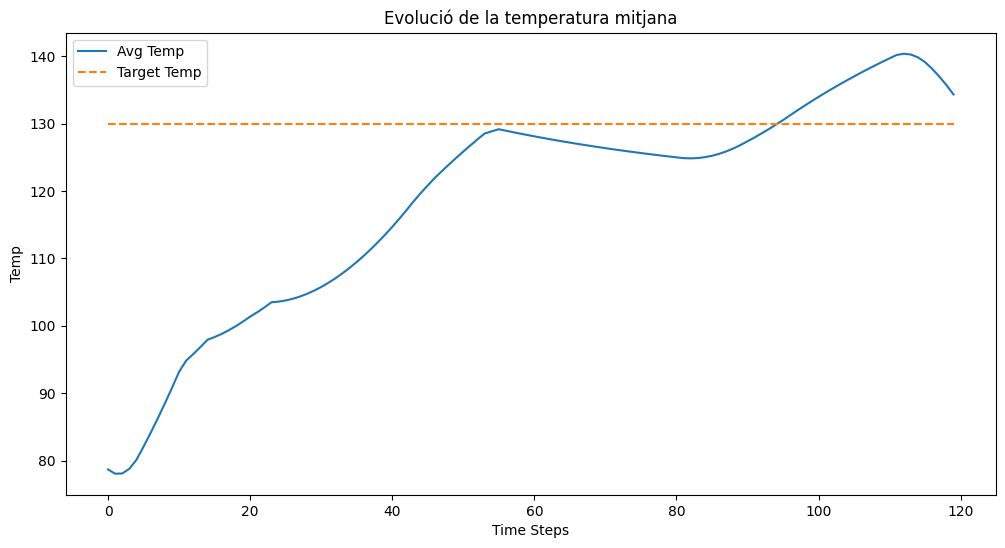

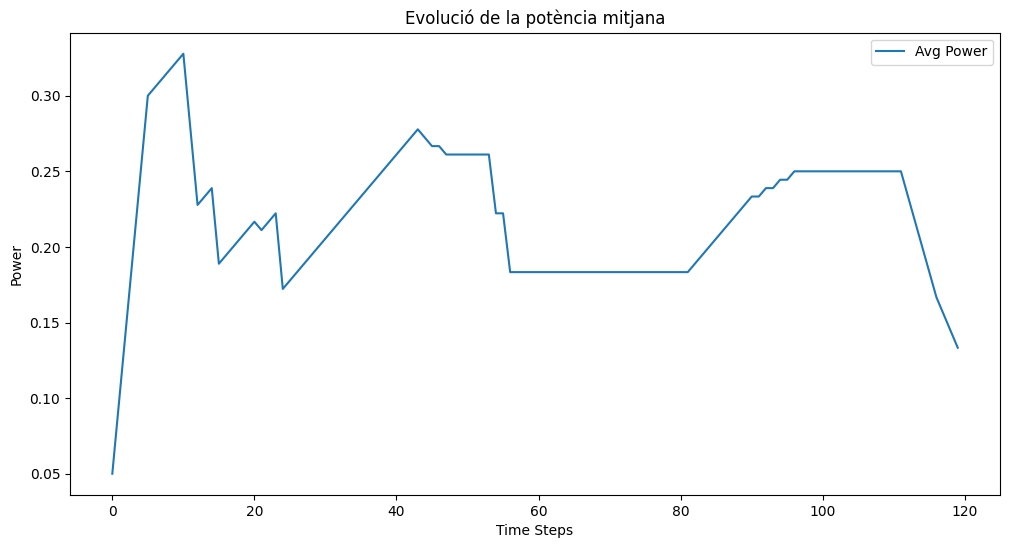

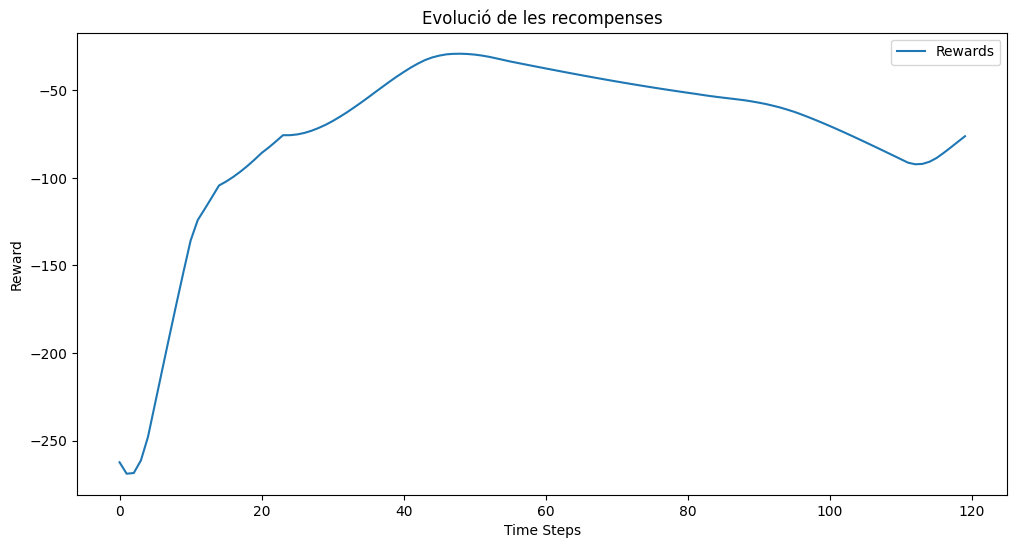

Temperatura final: 134.30646
Desviació estàndard: 27.438007


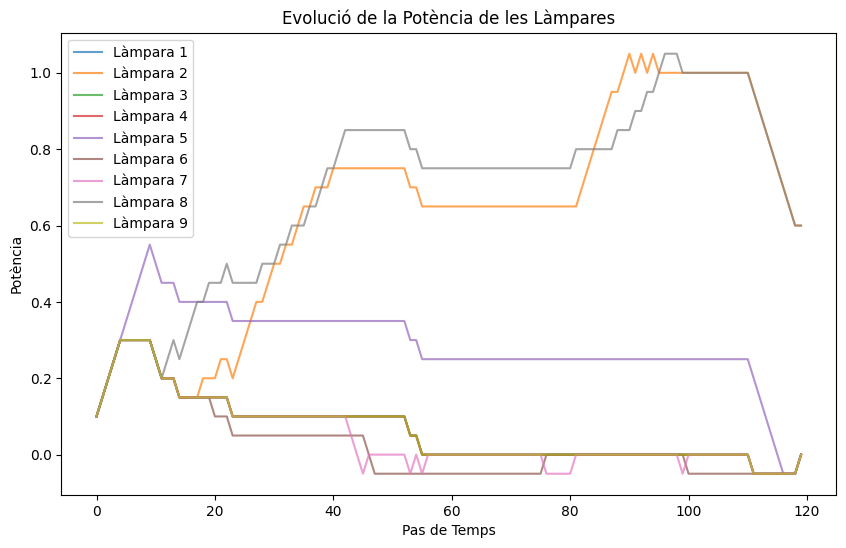

In [121]:
model = DQN.load('./best1/best_model.zip')


obs, _ = env_eval.reset()
info_history = []
lamps = []

for i in range(500):
  action, _ = model.predict(obs, deterministic=True)
  action = int(action) # Gràcies Forum

  obs, reward, terminated, truncated, info = env_eval.step(action)

  info_history.append(info)

  lamps.append(env_eval.lamp_power)

  if truncated or terminated:
      break

analyze_run(info_history)

final_temperature  = env_eval.temperature
print("Temperatura final:", np.mean(final_temperature))
print("Desviació estàndard:", np.std(final_temperature))


def plot_lamps(lamps):
  plt.figure(figsize=(10, 6))
  for i in range(N_LAMPS):
    plt.plot(lamps[:, i], label=f'Làmpara {i+1}', alpha=0.7)

  plt.title('Evolució de la Potència de les Làmpares')
  plt.xlabel('Pas de Temps')
  plt.ylabel('Potència')
  plt.legend()
  plt.show()

plot_lamps(np.array(lamps))

Pel que es pot veure en aquesta execució, el rendiment és pijor al obtingut amb els millors hiperparàmetres per a l'exercici 3.2. També és pijor al rendiment dels hiperparàmetres d'execució ràpida. La temperatura incrementa poc a poc en els 50 primers episodis fins aplegar a la temperatura objectiu. S'ha de recalcar, que una vegada més s'ha detectat prou variabilitat en l'entrenament per als mateixos parametres, cosa que atribuisc a la gestió de les lampares, ja que això abans amb la gestió de la mitjana no ocorria.

La gràfica de potència mitjana mostra un intent per incrementar la temperatura rapidament i mantenir-la quan s'aproxima a l'objectiu. La de recompenses mostra inestabilitat a l'hora de saber gestionar la potència de les lampares. Aproximant-se a la temperatura objectiu i després no sabent reduïr-la. En general un rendiment prou pijor que a l'apartat 3.2.

En aquest punt s'ha introduït també l'anàlisi de la potència de cada lampara. Pel que sembla, el principal problema d'aquest agent és la gestió de la potència de les lampares, ja que no sap que fer amb elles. Al principi les incrementa prou per aconseguir la temperatura desitjada, però després deixa tota la feina a soles dues; mentre la resta les redueix molt o les apaga. En general crec que el principal problema ha estat el intentar que l'agent gestione les lampares.

Si ho comparem amb l'execució del 3.2, a mi em sembla que la implementació a través de valors mitjans redueix prou la complexitat de l'afinament del model i amb aquest (gestionant lampares) no s'aconsegueix tampoc cap millora respecte al del 3.2.

Quan he executat el 3.2 amb els hiperparàmetres més optims (els que s'utilitzen en aquest exercici) m'ha donat un resultat considerablement millor que aquest. I si ho comparem amb els hiperparàmetres del model 3.2 per al menor temps d'execució, també m'ha donat millors resultats en menor temps d'entrenament Per tot això, jo em quedaria amb el 3.2 amb millors hiperparàmetres.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<strong>Exercici 3.4 (2 punts):</strong>

  Entrenament A2C. Utilitzarem ara l'espai d'accions LampArrayPowerModifications_continuous. Degut a que l'espai d'accions és continu, no podem fer servir el model DQN. Farem servir, per tant, el model A2C.

Entreneu el model provant de modificar els hiperparàmetres:



*   n_steps = [3,5,10] amb ent_coef = 0.1
*   ent_coef = [0,0.1,1] amb n_steps = 5

Feu servir 30 mil iteracions en tots els casos.


Comenta l'efecte d'ambdós paràmetres en el resultat final i compara els resultats de l'agent en aquest cas amb el que s'ha vist en els dos casos anteriors.
</div>


In [22]:
#No modificar res d'aqui
actions = LampArrayPowerModifications_continious(N_LAMPS)


observation_space = TemperatureEnvObservation(temperature_mode='lamp',
                          power_mode = 'lamp',
                          normalize_temperature=False,
                          return_power = True,
                          buffer_size = 2)

reward_method = 'negative_error'
env = TemperatureEnv(N,
               K,
               SIG,
               To,
               CONV_COEF,
               actions,
               observation_space,
               reward_method = reward_method)

env_eval = env = TemperatureEnv(N,
               K,
               SIG,
               To,
               CONV_COEF,
               actions,
               observation_space,
               reward_method = reward_method,
               is_eval = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
from stable_baselines3 import A2C
import torch as th
import os

# Definir els valors a provar
n_steps_values = [3, 5, 10]
ent_coef_values = [0, 0.1, 1]

policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[128, 64, 32, 9], vf=[128, 64, 32, 9]))

resultats_grid_search = []

for n_steps in n_steps_values:
    for ent_coef in ent_coef_values:
        # Definir el nom del model
        model_name = f'model_nsteps_{n_steps}_entcoef_{ent_coef}.zip'
        # Guardar en directori
        os.makedirs(model_name, exist_ok=True)

        # Crear el model amb els paràmetres de la iteració actual
        model = A2C("MlpPolicy",
                    env,
                    policy_kwargs=policy_kwargs,
                    learning_rate=0.01,
                    n_steps=n_steps,
                    ent_coef=ent_coef
                    )

        callback = EvalCallback(eval_env=env_eval, eval_freq=5000,
                                best_model_save_path='./' + model_name,
                                )

        initial_eval = evaluate_policy(model, env, n_eval_episodes=5)

        model.learn(total_timesteps=40000,
                    callback=callback,
                    progress_bar=True)

        final_eval = evaluate_policy(model, env, n_eval_episodes=5)

        model_control = f"Model entrenat amb n_steps={n_steps} i ent_coef={ent_coef}"

        # Emmagatzemar els resultats
        resultats_grid_search.append({
            'model_control': model_control,
            'initial_eval': initial_eval,
            'final_eval': final_eval
        })

for result in resultats_grid_search:
  print(result['model_control'])
  print(f"Initial Evaluation: {result['initial_eval']}")
  print(f"Final Evaluation: {result['final_eval']}")
  print("\n")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Eval num_timesteps=5000, episode_reward=-119370.13 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-278765.64 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-204730.95 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-204730.95 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-144491.07 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-137193.86 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-48992.24 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=-28947.67 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Output()

Eval num_timesteps=5000, episode_reward=-58172.63 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-241677.53 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-40990.02 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=20000, episode_reward=-48861.40 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-238643.53 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-238643.53 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-119224.25 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-204440.03 +/- 0.00

Episode length: 120.00 +/- 0.00

Output()

Eval num_timesteps=5000, episode_reward=-330867.16 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-137193.86 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=15000, episode_reward=-137193.86 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-137193.86 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-137193.86 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-137193.86 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-137193.86 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-137193.86 +/- 0.00

Episode length: 120.00 +/- 0.00

Output()

Eval num_timesteps=5000, episode_reward=-576887.50 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-337060.11 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=15000, episode_reward=-52260.39 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=20000, episode_reward=-136282.30 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-47040.88 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=30000, episode_reward=-394980.90 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-95810.67 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-20950.88 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Output()

Eval num_timesteps=5000, episode_reward=-78392.22 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-124373.02 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-137193.86 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-26688.56 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=25000, episode_reward=-18562.52 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=30000, episode_reward=-18637.51 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-18673.90 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-18562.52 +/- 0.00

Episode length: 120.00 +/- 0.00

Output()

Eval num_timesteps=5000, episode_reward=-539451.59 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-693699.70 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-576887.50 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-426835.43 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=25000, episode_reward=-647029.95 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-577321.53 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-89615.51 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=-119632.23 +/- 0.00

Episode length: 120.00 +/- 0.00

Output()

Eval num_timesteps=5000, episode_reward=-98996.16 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-112750.27 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-115789.67 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-359091.28 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-121088.67 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-121088.67 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-69277.34 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=-65504.77 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Output()

Eval num_timesteps=5000, episode_reward=-62296.57 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-91014.15 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-87753.91 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-131925.14 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-64138.58 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-19490.45 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=35000, episode_reward=-17259.50 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=-69212.60 +/- 0.00

Episode length: 120.00 +/- 0.00

Output()

Eval num_timesteps=5000, episode_reward=-103034.22 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=-136236.45 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-137056.36 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-135941.86 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-136624.44 +/- 0.00

Episode length: 120.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-33205.53 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=35000, episode_reward=-20070.98 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=-18996.06 +/- 0.00

Episode length: 120.00 +/- 0.00

New best mean reward!

Model entrenat amb n_steps=3 i ent_coef=0
Initial Evaluation: (-217714.97775268555, 0.0)
Final Evaluation: (-28715.810607910156, 0.0)


Model entrenat amb n_steps=3 i ent_coef=0.1
Initial Evaluation: (-28901.02328300476, 0.0)
Final Evaluation: (-204440.02507209778, 0.0)


Model entrenat amb n_steps=3 i ent_coef=1
Initial Evaluation: (-58253.24378967285, 0.0)
Final Evaluation: (-137193.86471557617, 0.0)


Model entrenat amb n_steps=5 i ent_coef=0
Initial Evaluation: (-45013.49279785156, 0.0)
Final Evaluation: (-20941.498275756836, 0.0)


Model entrenat amb n_steps=5 i ent_coef=0.1
Initial Evaluation: (-240930.8687133789, 0.0)
Final Evaluation: (-18562.517684936523, 0.0)


Model entrenat amb n_steps=5 i ent_coef=1
Initial Evaluation: (-168032.73818969727, 0.0)
Final Evaluation: (-118749.7653503418, 0.0)


Model entrenat amb n_steps=10 i ent_coef=0
Initial Evaluation: (-415795.17253112793, 0.0)
Final Evaluation: (-65531.12322998047, 0.0)


Model entrenat amb n_steps=10 i ent_coef=0.1
Init

VALORS PROVATS:

Model entrenat amb n_steps=3 i ent_coef=0
Initial Evaluation: (-217714.97775268555, 0.0)
Final Evaluation: (-28715.810607910156, 0.0)

Model entrenat amb n_steps=3 i ent_coef=0.1
Initial Evaluation: (-28901.02328300476, 0.0)
Final Evaluation: (-204440.02507209778, 0.0)

Model entrenat amb n_steps=3 i ent_coef=1
Initial Evaluation: (-58253.24378967285, 0.0)
Final Evaluation: (-137193.86471557617, 0.0)

Model entrenat amb n_steps=5 i ent_coef=0
Initial Evaluation: (-45013.49279785156, 0.0)
Final Evaluation: (-20941.498275756836, 0.0)

Model entrenat amb n_steps=5 i ent_coef=0.1
Initial Evaluation: (-240930.8687133789, 0.0)
Final Evaluation: (-18562.517684936523, 0.0)

Model entrenat amb n_steps=5 i ent_coef=1
Initial Evaluation: (-168032.73818969727, 0.0)
Final Evaluation: (-118749.7653503418, 0.0)

Model entrenat amb n_steps=10 i ent_coef=0
Initial Evaluation: (-415795.17253112793, 0.0)
Final Evaluation: (-65531.12322998047, 0.0)

Model entrenat amb n_steps=10 i ent_coef=0.1
Initial Evaluation: (-108665.41177749634, 0.0)
Final Evaluation: (-68221.25927734375, 0.0)

Model entrenat amb n_steps=10 i ent_coef=1
Initial Evaluation: (-147944.14097976685, 0.0)
Final Evaluation: (-19009.231857299805, 0.0)

////////////////////////////////////////////////////////////////////////////////

VALORS DEMANATS:

Model entrenat amb n_steps=3 i ent_coef=0.1
Initial Evaluation: (-28901.02328300476, 0.0)
Final Evaluation: (-204440.02507209778, 0.0)

Model entrenat amb n_steps=5 i ent_coef=0.1
Initial Evaluation: (-240930.8687133789, 0.0)
Final Evaluation: (-18562.517684936523, 0.0)

Model entrenat amb n_steps=10 i ent_coef=0.1
Initial Evaluation: (-108665.41177749634, 0.0)
Final Evaluation: (-68221.25927734375, 0.0)

////////////////////////////////////////////////////////////////////////////////

Model entrenat amb n_steps=5 i ent_coef=0
Initial Evaluation: (-45013.49279785156, 0.0)
Final Evaluation: (-20941.498275756836, 0.0)

Model entrenat amb n_steps=5 i ent_coef=0.1
Initial Evaluation: (-240930.8687133789, 0.0)
Final Evaluation: (-18562.517684936523, 0.0)

Model entrenat amb n_steps=5 i ent_coef=1
Initial Evaluation: (-168032.73818969727, 0.0)
Final Evaluation: (-118749.7653503418, 0.0)

////////////////////////////////////////////////////////////////////////////////

Sembla que el millor model és el de n_steps = 5 i ent_coef = 0.1



Mostre resultats de: model_nsteps_5_entcoef_0.1.zip
model_nsteps_5_entcoef_0.1.zip


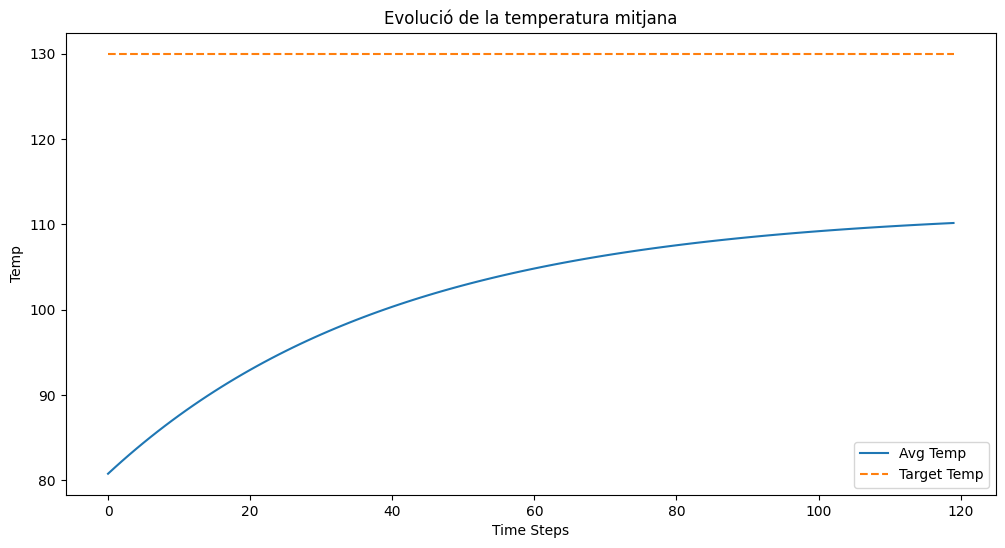

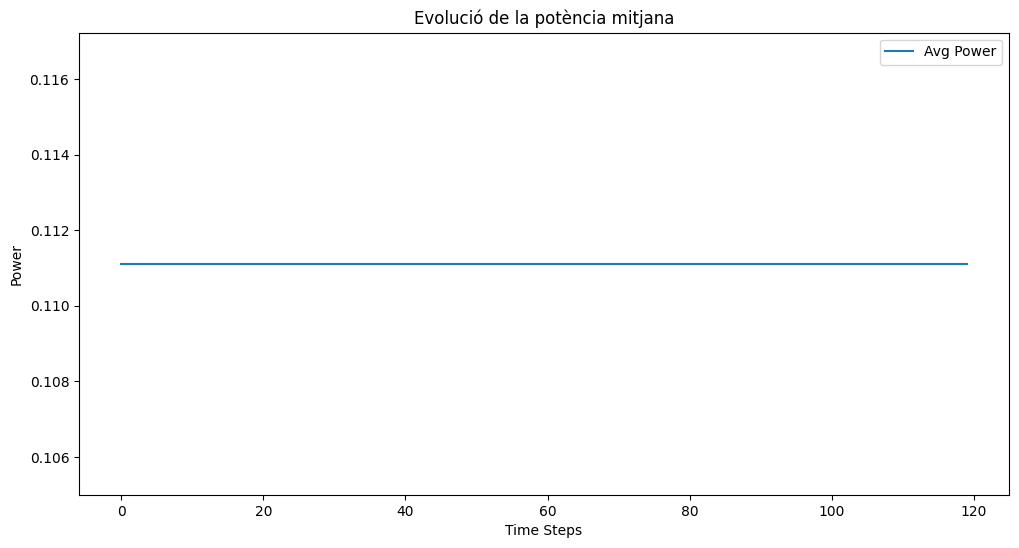

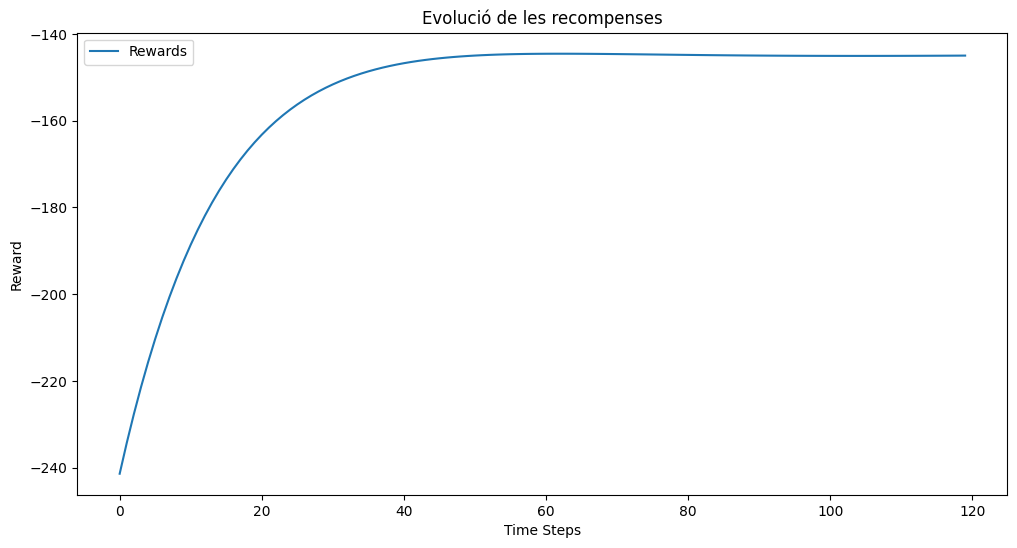

Temperatura final (n_steps=5, ent_coef=0.1): 110.16434
Desviació estàndard (n_steps=5, ent_coef=0.1): 32.656723


In [25]:
n_steps = 5
ent_coef = 0.1

policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[128, 64, 32, 9], vf=[128, 64, 32, 9]))

# Definir el nom
model_name = f'model_nsteps_{n_steps}_entcoef_{ent_coef}.zip'
model_path = './' + model_name

print(f'Mostre resultats de: {model_name}')

if os.path.exists(model_path):
  model = A2C.load(model_path + '/best_model.zip')
  # Reset dels valors necessaris per a l'avaluació
  obs, _ = env_eval.reset()
  info_history = []

  # Loop d'avaluació
  while True:
      action, _ = model.predict(obs, deterministic=True)
      obs, reward, terminated, truncated, info = env_eval.step(action)
      info_history.append(info)

      if truncated or terminated:
          break

  # Anàlisi de l'execució
  print(f'{model_name}')
  analyze_run(info_history)
  final_temperature = env_eval.temperature
  print(f"Temperatura final (n_steps={n_steps}, ent_coef={ent_coef}):", np.mean(final_temperature))
  print(f"Desviació estàndard (n_steps={n_steps}, ent_coef={ent_coef}):", np.std(final_temperature))

El n-steps sembla que atenua els canvis bruscos de l'agent en el control de les lampares, mentre que el ent_coef afavoreix l'exploració a través d'entropia. Cosa que a valors elevats desfa el rendiment de l'agent.

Els millors resultats d'aquests paràmetres tampoc són millors que els de l'algorisme aconseguit amb els millors hiperparàmetres del 3.2. Encara pijors que els resultas obtinguts al 3.3.

Pel que s'observa, les recompenses s'incrementen perquè la temperatura s'incrementa de manera constant, però mai aplega al target. La clau trobe que està en el gràfic de la potència mitjana, on s'hi veu que la potència mitjana és constant. És possible, a més tractant-se de la tendència que te l'agent A2C, que a l'entrenament s'haja trobat un màxim local que haja impedit seguir entrenant a l'agent. Per això veiem que la potència no varia. L'agent ha aprés que com la temperatura va pujant i les recompenses creixent, no li cal incrementar la temperatura bruscament ja que aplegarà a la temperatura objectiu a l'infinit.

Clarament no tenim temps infinit. Per tot això, jo diria que la millor aproximació ha sigut l'exercici 3.2 amb temperatures mitjanes, DQN i amb els millors hiperparàmetres trobats.